# Identity
Deep Learning Final Exam | 1. LSTM\
Name: Michelle Nathania\
Student ID: 2702208575 (odd)

# Import Necessary Libraries

In [ ]:
pip install keras-tuner

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

import missingno as msno

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import keras_tuner as kt

# Import dataset

In [ ]:
df = pd.read_csv("AP004.csv")
# df = df.sort_values('Order Date')

# a. EDA and Data Preprocessing
Checking the data features is important because we can understand how is our data, is it good or not, and do proper preprocessing so the data is suitable for the training process.

In [ ]:
# Check dataset
df.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),Eth-Benzene (ug/m3),MP-Xylene (ug/m3),Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-09-05 14:00:00,2017-09-05 15:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,79.50,0.10,3.50,NaN,0.10,30.30,69.00,3.20,213.00,372.00,747.00,0.10,33.80,0.00,0.50
1,2017-09-05 15:00:00,2017-09-05 16:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,62.50,0.15,2.83,NaN,0.08,30.00,70.50,4.10,140.00,290.75,747.25,0.05,32.22,0.00,0.48
2,2017-09-05 16:00:00,2017-09-05 17:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,40.50,0.53,3.05,NaN,0.13,29.85,88.00,2.82,174.75,300.25,747.00,0.00,28.30,0.93,0.53
3,2017-09-05 17:00:00,2017-09-05 18:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,34.43,0.48,4.88,NaN,0.28,29.25,88.75,1.72,231.50,225.50,747.75,0.00,28.77,0.00,1.85
4,2017-09-05 18:00:00,2017-09-05 19:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,33.00,0.57,5.15,NaN,0.38,28.05,88.50,1.97,105.25,11.25,748.25,0.00,28.25,0.00,2.17


Here is the first 5 rows of the data. We can see that it has many columns and all datatype is numerical. All data looks like it spans for only one hour. However, this is only concluded on the observed data at a glance, so to be sure, it is better to do double checking.

In [ ]:
df['From Date'] = pd.to_datetime(df['From Date'])
df['To Date'] = pd.to_datetime(df['To Date'])
df['duration_minutes'] = (df['To Date'] - df['From Date']).dt.total_seconds() / 60

print(df['duration_minutes'].value_counts())

duration_minutes
60.0    48802
Name: count, dtype: int64


By subtracting the To Date by From Date, we can see that all data points are 60 minutes apart. Therefore, the 'To Date' column can be removed since the 'From Date' index i is basically the same as 'From Data' index i+1 - i. To put it simply, the 'To Date' is redundant and we do not need it.

We also  sort the data based on 'From Date' because we only need the data to be present, sorted by the time, because time series modeling such as LSTM will depend heavily on the order of data!:D

In [ ]:
df = df.sort_values('From Date').reset_index(drop=True)
df = df.drop(['To Date', 'duration_minutes'], axis=1)
df.head()

,From Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),Eth-Benzene (ug/m3),MP-Xylene (ug/m3),Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-09-05 14:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,79.50,0.10,3.50,NaN,0.10,30.30,69.00,3.20,213.00,372.00,747.00,0.10,33.80,0.00,0.50
1,2017-09-05 15:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,62.50,0.15,2.83,NaN,0.08,30.00,70.50,4.10,140.00,290.75,747.25,0.05,32.22,0.00,0.48
2,2017-09-05 16:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,40.50,0.53,3.05,NaN,0.13,29.85,88.00,2.82,174.75,300.25,747.00,0.00,28.30,0.93,0.53
3,2017-09-05 17:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,34.43,0.48,4.88,NaN,0.28,29.25,88.75,1.72,231.50,225.50,747.75,0.00,28.77,0.00,1.85
4,2017-09-05 18:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,33.00,0.57,5.15,NaN,0.38,28.05,88.50,1.97,105.25,11.25,748.25,0.00,28.25,0.00,2.17


In [ ]:
df.tail()

,From Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
48797,2023-03-31 19:00:00,10.75,29.25,2.98,8.18,6.77,6.10,8.90,0.50,7.12,...,NaN,67.00,4.97,186.25,3.0,751.75,0.06,33.58,0.0,0.53
48798,2023-03-31 20:00:00,9.75,28.75,3.15,9.88,7.77,6.10,10.43,0.68,7.28,...,NaN,70.75,3.70,162.75,3.0,752.00,0.07,32.52,0.0,0.50
48799,2023-03-31 21:00:00,16.75,33.75,2.95,14.32,10.00,7.90,12.17,0.86,7.05,...,NaN,73.25,3.33,128.75,3.0,752.50,0.07,31.20,0.0,0.75
48800,2023-03-31 22:00:00,12.75,34.75,1.98,13.60,8.80,10.12,18.57,0.76,7.02,...,NaN,75.00,3.55,120.25,3.5,753.00,0.06,30.85,0.0,0.70
48801,2023-03-31 23:00:00,12.00,40.00,1.87,12.73,8.30,9.50,17.17,0.37,7.70,...,NaN,75.00,3.03,123.00,3.0,753.00,0.05,30.80,0.0,0.43


In [ ]:
# Get min and max timestamp
start_date = df["From Date"].min()
end_date = df["From Date"].max()

print("Time coverage from", start_date, "to", end_date)

Time coverage from 2017-09-05 14:00:00 to 2023-03-31 23:00:00


The dataset spans for approximately 5.5 years from September 2017 to March 2023. We have lots of dataset here! And since the gaps are all 60 minutes (1 hour), there is no missing gap between the data, so we can confirm that all data point is one hour apart.

## Check the number of rows & columns
This is important so we understand how many data points and features we have. More data points may result to better training if it helps the model learns the pattern better!

In [ ]:
print(f"# of rows: ", df.shape[0])
print(f"# of columns: ", df.shape[1])

# of rows:  48802
# of columns:  24


We have 48802 data points and 24 features. Those are sufficient for training a robust model for LSTM. Now, let's check the data quality, because many data points without good quality is basically bad for the training.

## Check general information
Checking general information using df.info() helps us to check the basic data quality, such as the number of non-null columns, what columns do we have, and the datatype at a glance. So, it's efficient!

In [ ]:
# Check dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48802 entries, 0 to 48801
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   From Date            48802 non-null  datetime64[ns]
 1   PM2.5 (ug/m3)        46344 non-null  float64       
 2   PM10 (ug/m3)         46917 non-null  float64       
 3   NO (ug/m3)           47244 non-null  float64       
 4   NO2 (ug/m3)          47224 non-null  float64       
 5   NOx (ppb)            46628 non-null  float64       
 6   NH3 (ug/m3)          47140 non-null  float64       
 7   SO2 (ug/m3)          46649 non-null  float64       
 8   CO (mg/m3)           46387 non-null  float64       
 9   Ozone (ug/m3)        47156 non-null  float64       
 10  Benzene (ug/m3)      46914 non-null  float64       
 11  Toluene (ug/m3)      46908 non-null  float64       
 12  Eth-Benzene (ug/m3)  23988 non-null  float64       
 13  MP-Xylene (ug/m3)    39256 non-

- We have 24 columns, as checked in the df.shape function.
- Most columns have null values, but the most severe ones are Eth-Benzene and Temperature.
- All datatype is numerical (float), perfect for modeling.

## Check null and duplicates
This is to confirm our suspicion regarding the null values, just to be sure of how many data points are missing and what is the percentage of the missing values.

Checking the duplicates is necessary because duplicated data points are redundant and potentially noise the data.

In [ ]:
df.isnull().sum()

,0
From Date,0
PM2.5 (ug/m3),2458
PM10 (ug/m3),1885
NO (ug/m3),1558
NO2 (ug/m3),1578
NOx (ppb),2174
NH3 (ug/m3),1662
SO2 (ug/m3),2153
CO (mg/m3),2415
Ozone (ug/m3),1646


In [ ]:
null_percent = df.isnull().mean() * 100
print(null_percent.sort_values(ascending=False))

Temp (degree C)        55.741568
Eth-Benzene (ug/m3)    50.846277
MP-Xylene (ug/m3)      19.560674
PM2.5 (ug/m3)           5.036679
CO (mg/m3)              4.948568
NOx (ppb)               4.454735
SO2 (ug/m3)             4.411704
Toluene (ug/m3)         3.880988
Benzene (ug/m3)         3.868694
PM10 (ug/m3)            3.862547
Xylene (ug/m3)          3.538789
NH3 (ug/m3)             3.405598
SR (W/mt2)              3.393304
Ozone (ug/m3)           3.372813
VWS (m/s)               3.331831
NO2 (ug/m3)             3.233474
NO (ug/m3)              3.192492
AT (degree C)           3.106430
RH (%)                  2.946601
WD (degree)             2.928159
BP (mmHg)               2.928159
WS (m/s)                2.924060
RF (mm)                 2.647432
From Date               0.000000
dtype: float64


-  Noticeable: It is confirmed that Eth-Benzene and Temperature has many missing values, around 50% (half of the data). Consider dropping the data as it may not be valuable, and imputing the data may lead to having too many synthetic data.
- The other columns also have null around 2% to 19%. We can impute these columns, but let's check the randomness of the missing values first to consider if we should impute the data, with which method, or just drop it.

<Axes: >

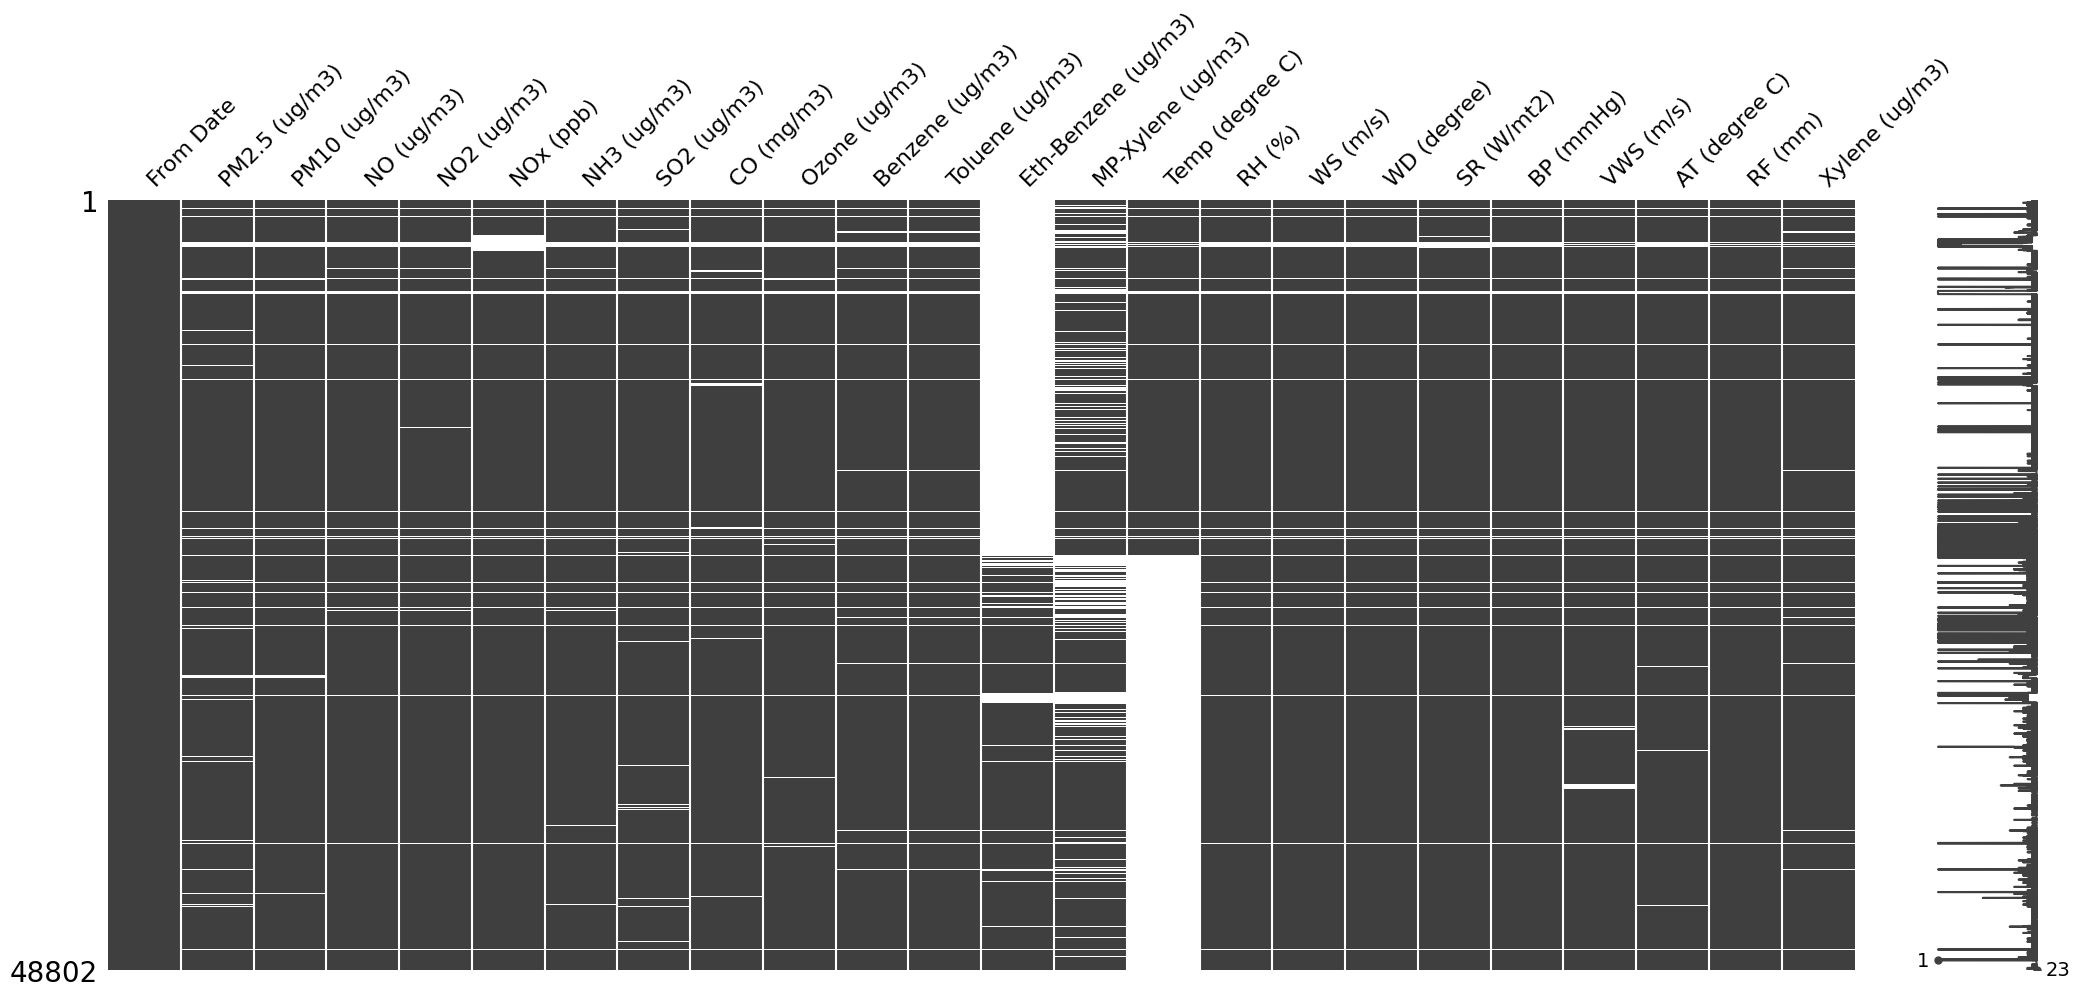

In [ ]:
msno.matrix(df)

- Eth-Benzene and Temp have too many null values, not enough for the modeling so it is not recoverable and better to drop the columns.
- MP-Xylene's missing values are spread, we can impute this using forward fill because using ffill matches the values with the last, non-null values. This approach is more suitable for time-series data because it respects the sequence and time period. Using mean or median for imputation may lead to the values in the same time period having fluctuations (let's say the missing value is at night 12:00AM where this value is usually low, but the mean value is high so it "messes" with the data).
- Other columns can be imputed with the same approach, ffill, for the same reason. bfill is not used here because it can give ideas of the next data (possible leakage), and since the null values are in the middle of the data, it is safe to use ffill.

In [ ]:
# Drop Eth-Benzene and Temp columns
df = df.drop(columns=['Eth-Benzene (ug/m3)', 'Temp (degree C)'])

In [ ]:
# Null imputation
df = df.ffill()

In [ ]:
df.isnull().sum()

,0
PM2.5 (ug/m3),0
PM10 (ug/m3),0
NO (ug/m3),0
NO2 (ug/m3),0
NOx (ppb),0
NH3 (ug/m3),0
SO2 (ug/m3),0
CO (mg/m3),0
Ozone (ug/m3),0
Benzene (ug/m3),0


After imputation, there is no more missing values in the data. Cool!

In [ ]:
# Check duplicated data
sum(df.duplicated())

0

This dataset does not have any duplicated value, so no duplicate handling will be performed.

In [ ]:
# Set index to 'From Date'
df = df.set_index('From Date')

The index is now set to 'From Date' because while this feature is important for time series model, it is not directly used.

In [ ]:
df.head()

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),MP-Xylene (ug/m3),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
From Date,,,,,,,,,,,,,,,,,,,,,
2017-09-05 14:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,79.50,0.10,3.50,0.10,69.00,3.20,213.00,372.00,747.00,0.10,33.80,0.00,0.50
2017-09-05 15:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,62.50,0.15,2.83,0.08,70.50,4.10,140.00,290.75,747.25,0.05,32.22,0.00,0.48
2017-09-05 16:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,40.50,0.53,3.05,0.13,88.00,2.82,174.75,300.25,747.00,0.00,28.30,0.93,0.53
2017-09-05 17:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,34.43,0.48,4.88,0.28,88.75,1.72,231.50,225.50,747.75,0.00,28.77,0.00,1.85
2017-09-05 18:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,33.00,0.57,5.15,0.38,88.50,1.97,105.25,11.25,748.25,0.00,28.25,0.00,2.17


## Numerical data distribution
This is to check the distribution of the data, whether it is normally distributed or not. Understanding this helps us to detect any outliers and understand which preprocessing method (such as choosing the scaler) is appropriate.

In [ ]:
# Check the numerical statistics
pd.set_option('display.max_columns', None)
print(df.describe())

       PM2.5 (ug/m3)  PM10 (ug/m3)    NO (ug/m3)   NO2 (ug/m3)     NOx (ppb)  \
count   48802.000000  48802.000000  48802.000000  48802.000000  48802.000000   
mean       34.597196     71.466791      2.506647     15.419985     10.177941   
std        30.839854     48.413886      4.993837     10.597449      7.179322   
min         0.250000      0.250000      0.030000      0.100000      0.000000   
25%        11.750000     34.250000      1.450000      8.500000      6.070000   
50%        24.500000     59.500000      1.900000     12.850000      8.620000   
75%        51.000000    100.000000      2.600000     19.400000     12.550000   
max       723.000000    835.500000    216.170000    166.250000    166.000000   

        NH3 (ug/m3)   SO2 (ug/m3)    CO (mg/m3)  Ozone (ug/m3)  \
count  48802.000000  48802.000000  48802.000000   48802.000000   
mean      13.563834      8.432681      0.685229      41.183301   
std        8.597677      6.123195      0.439458      32.657793   
min        0.10

### Values Breakdown
- PM2.5, PM10 (Particulate Matters under 2.5 micrometers and 10 micrometers respectively)
	- Mean are higher than median which suggests right skewness.
	- Max values of 723 and 835.5 are extremely high, representing severe pollution events. They are higher than the 75% of the data, suggesting they are outliers.
- NO, NO2, NOx (Nitrogen Oxides), SO2 (Sulfur Dioxide), NH3 (Ammonia), CO (Carbon Monoxide), Ozone, Benzene, Toluene, MP-Xylene
	- Overall suggests normal range
	- Max values are all too high compared to the average and 75% of the data. This indicates high-emission events (outliers).
- RH% (Relative Humidity)
	- Range is normal from 15% to 100% (considering the percentage value), but 100% relative humidity..? 😓 it is way too humid and uncomfortable! The "normal" range is between 30% to 60%. Though, these values will be kept as is since it is technically possible.
- BP (Barometric Pressure)
	- Ranges around 700 mmHg which is normal for barometric pressure, but 808 mmHg is considered high.
- WS & VWS (Wind Speed & Vertical Wind Speed)
	- Normal wind speed is around 0 to 15 m/s (15 m/s is equal to 54 km/h, about average driving speed). However, the maximum value is 45.9 m/s which is equal to 165.6 km/h which is incredibly extreme. I think the machine could break at this point due to the extreme wind speed 😅
	- Negative VWS indicates downward motion of the wind which is normal
- WD (Wind Direction)
	- Ranges from 45 to 326 degree that is still normal since the range for degree is from 0 to 360
- SR (Solar Radiation)
	- The minimum of 0 is possible at night and the maximum of 455 is also normal. The SR on sea on a clear day can reach up to 1000 W/mt2

---

### Conclusion
- Transformation will be done because LSTM is sensitive to the scale of input values. Values with different ranges can make training unstable.
- The data has many outliers, so Robust Scaler will be used. .fit_transform() will be applied for train data, while .transform() will be applied for test data.

## Numerical visualization

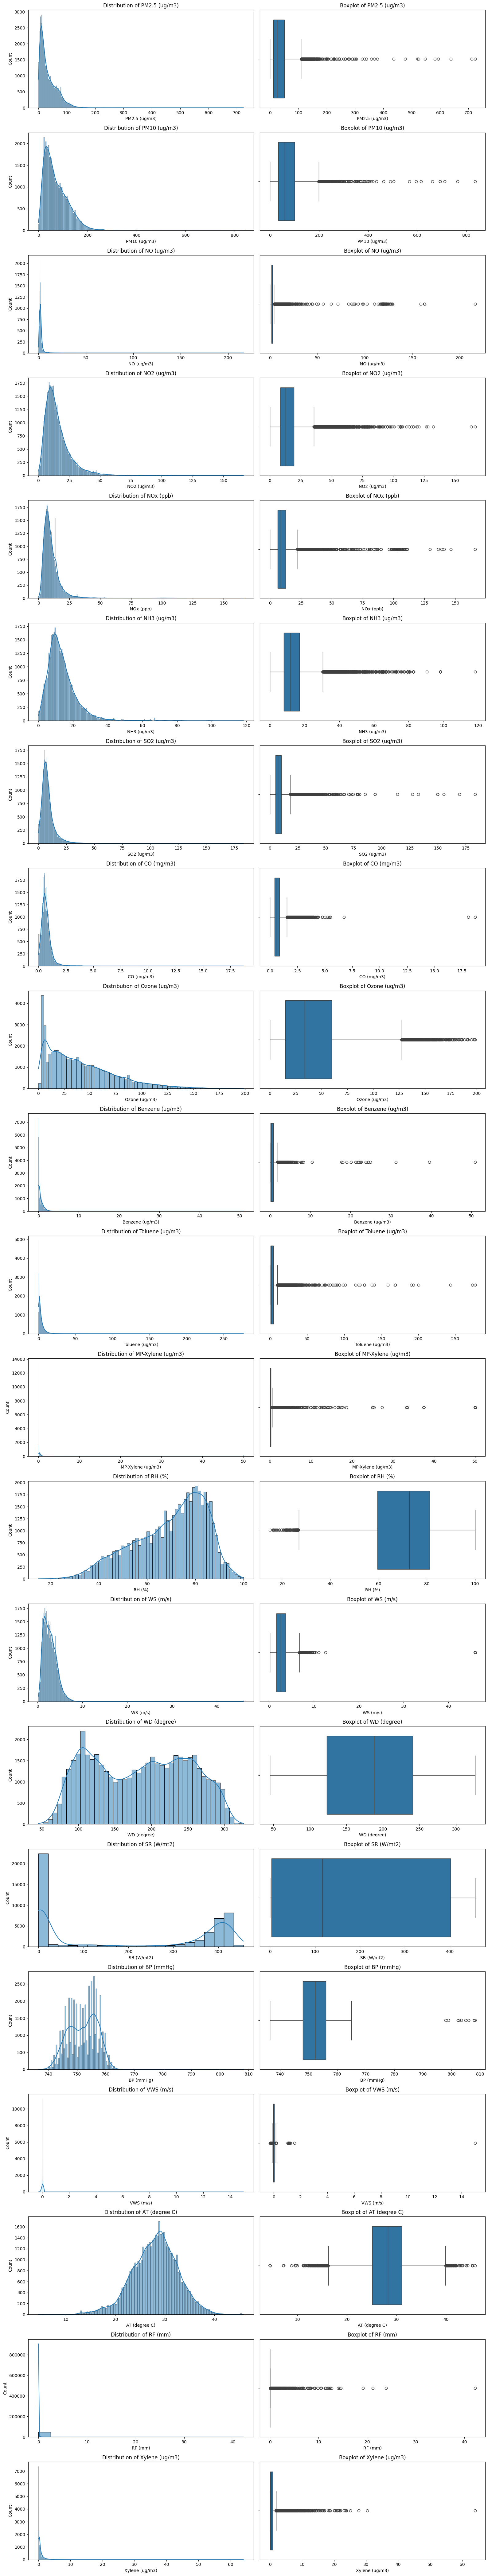

In [ ]:
plt.figure(figsize=(16, 4 * len(df.columns)))

for i, col in enumerate(df.columns):
    plt.subplot(len(df.columns), 2, 2*i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')

    plt.subplot(len(df.columns), 2, 2*i + 2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [ ]:
# Check skewness
df.skew()

,0
PM2.5 (ug/m3),2.596626
PM10 (ug/m3),1.465230
NO (ug/m3),21.174782
NO2 (ug/m3),2.291618
NOx (ppb),5.233098
NH3 (ug/m3),2.302773
SO2 (ug/m3),4.382971
CO (mg/m3),4.603901
Ozone (ug/m3),1.061790
Benzene (ug/m3),15.900073


The visualization is necessary to confirm the findings we observed earlier. It is confirmed that most of the variables are skewed (supported with the skewness value as well). The data with low-to-no skewness are WD, SR, BP, and AT, but the ones with no detected outliers in the boxplot are WD and SR. However, we can still use Robust Scaler for every features.

## Visualize trends
Understanding trends may be an additional useful information for us when it comes to time series analysis. We can check the data quality here, if it makes sense, or if it has patterns that help the model learn easier.

/tmp/ipython-input-23-1217360156.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


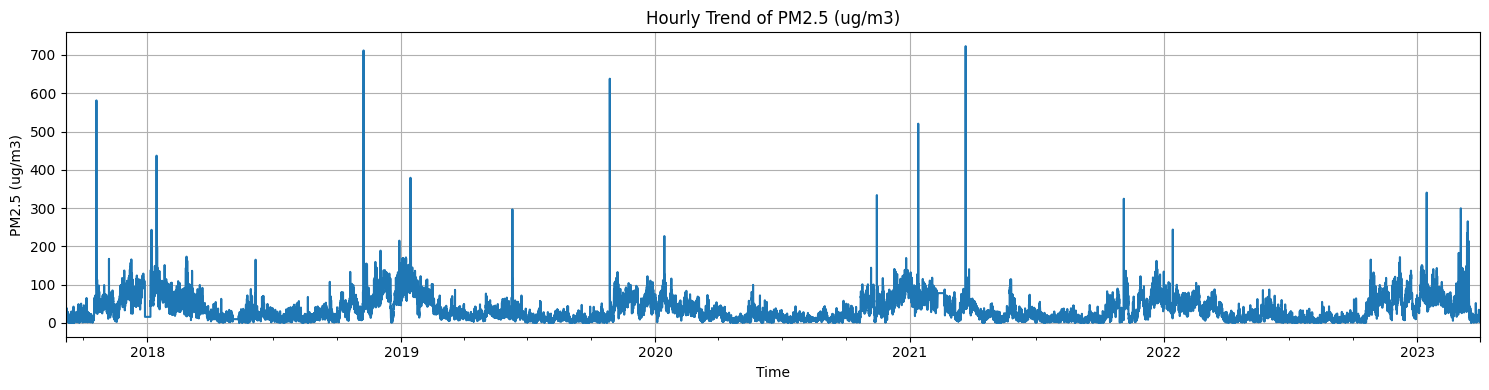

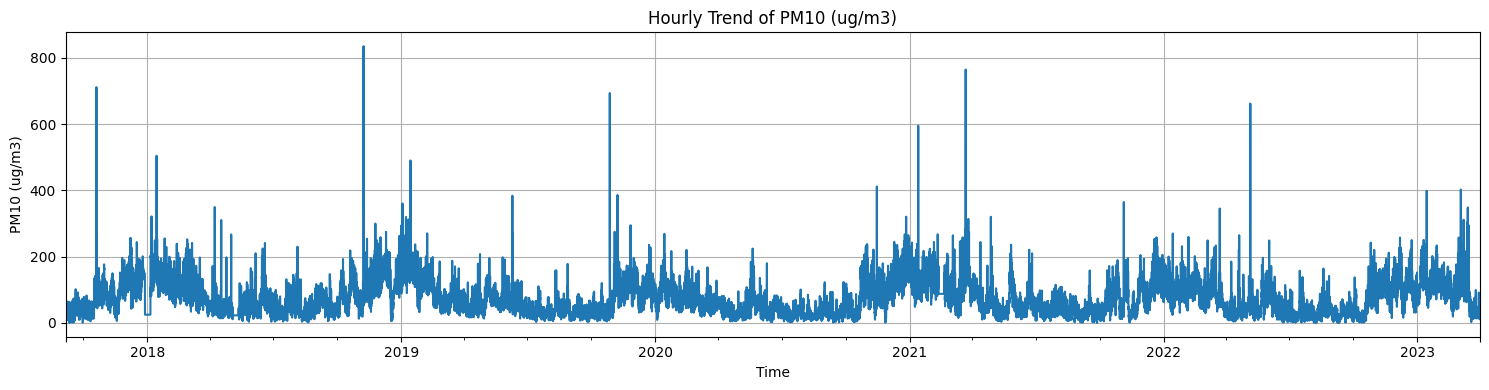

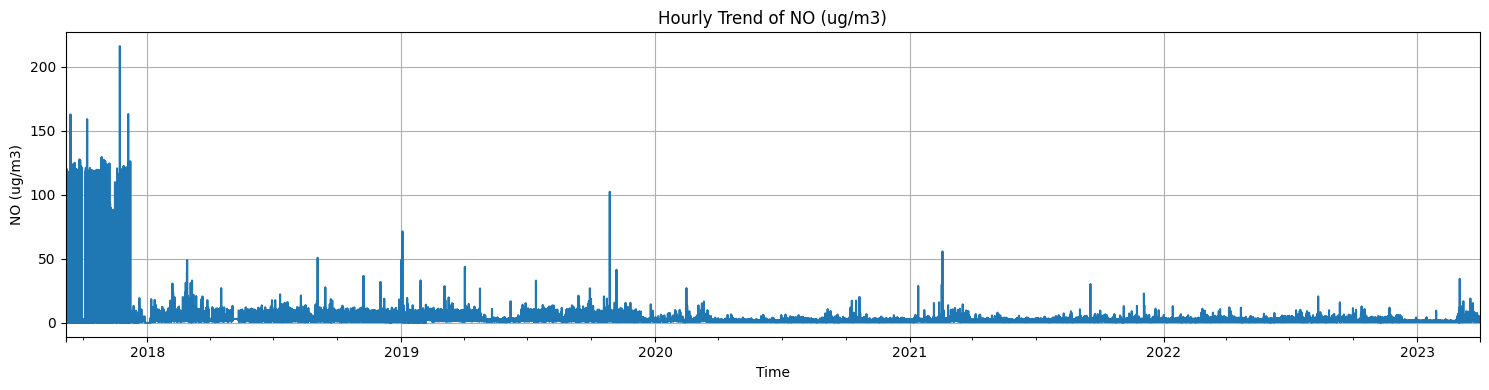

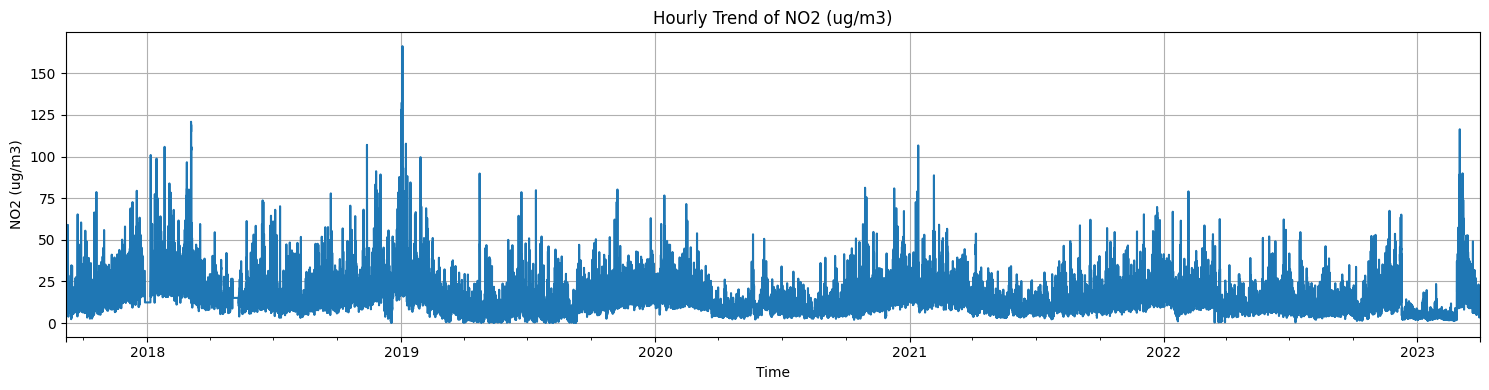

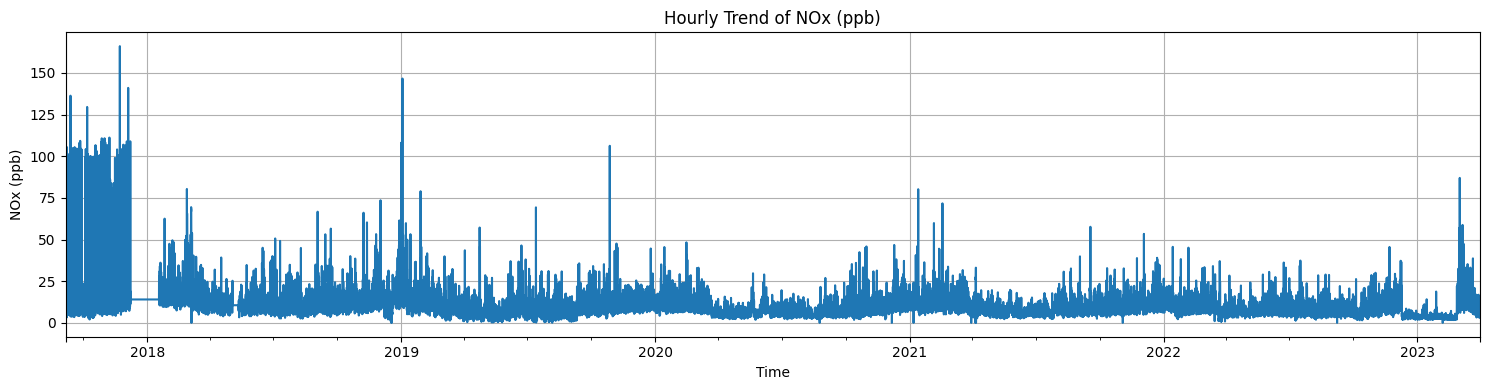

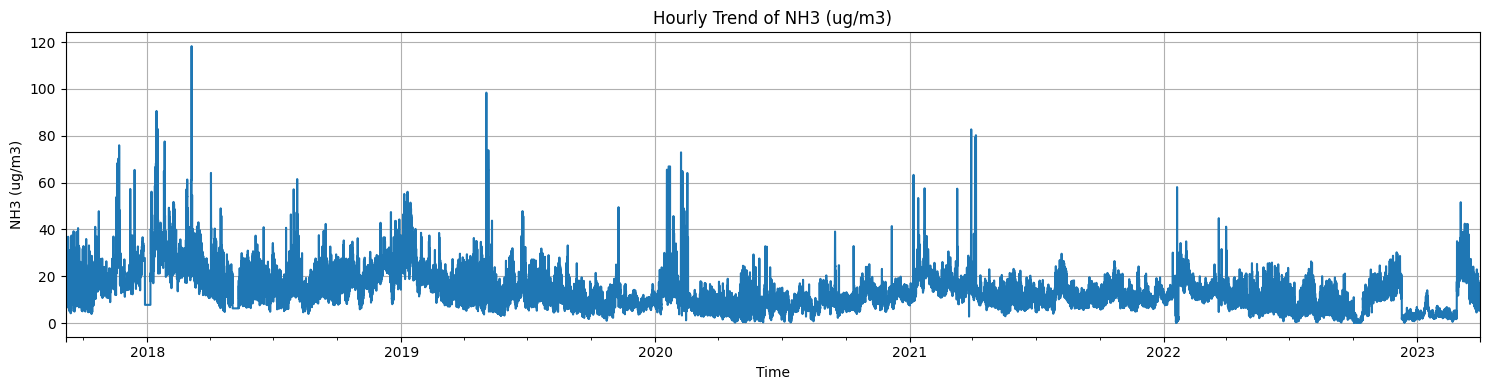

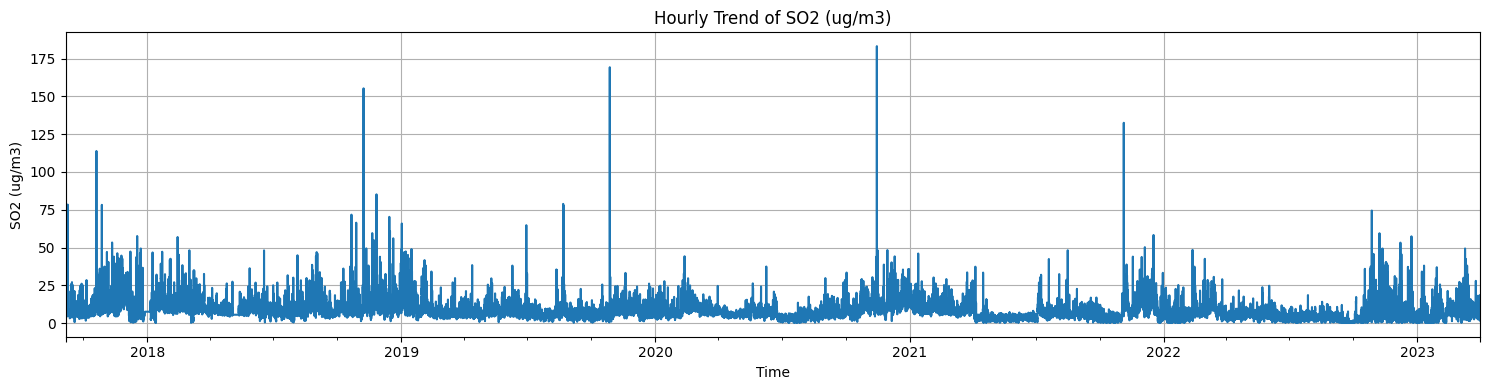

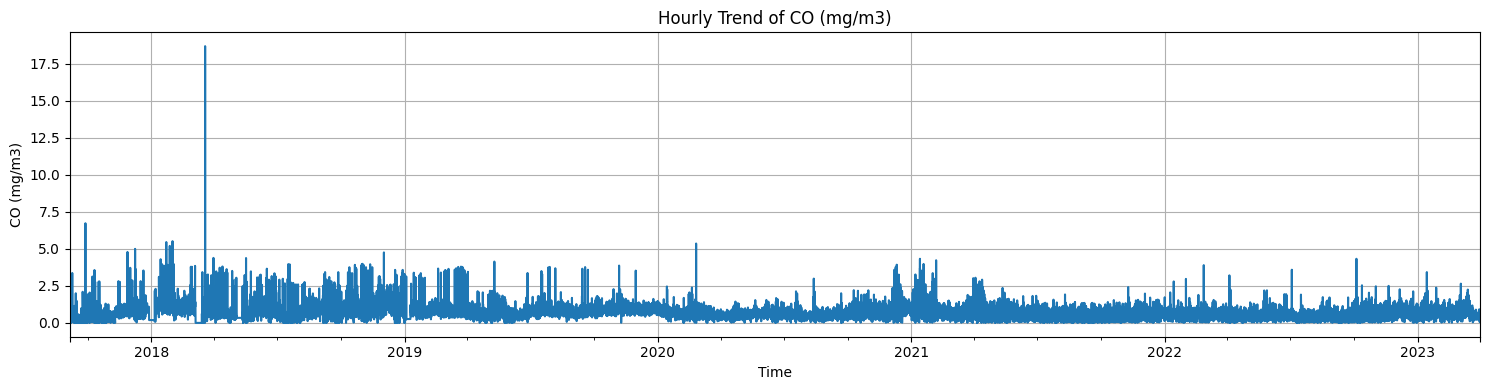

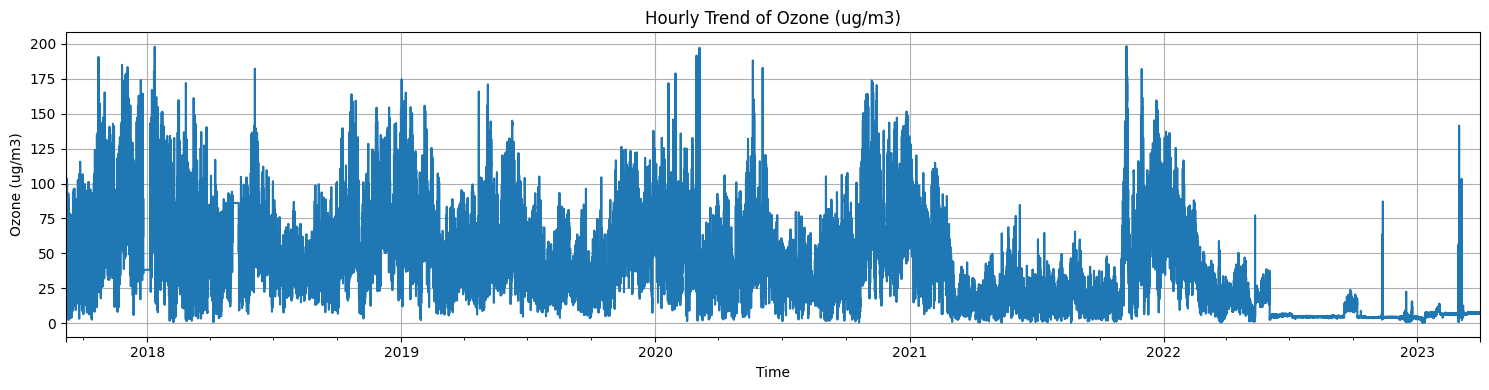

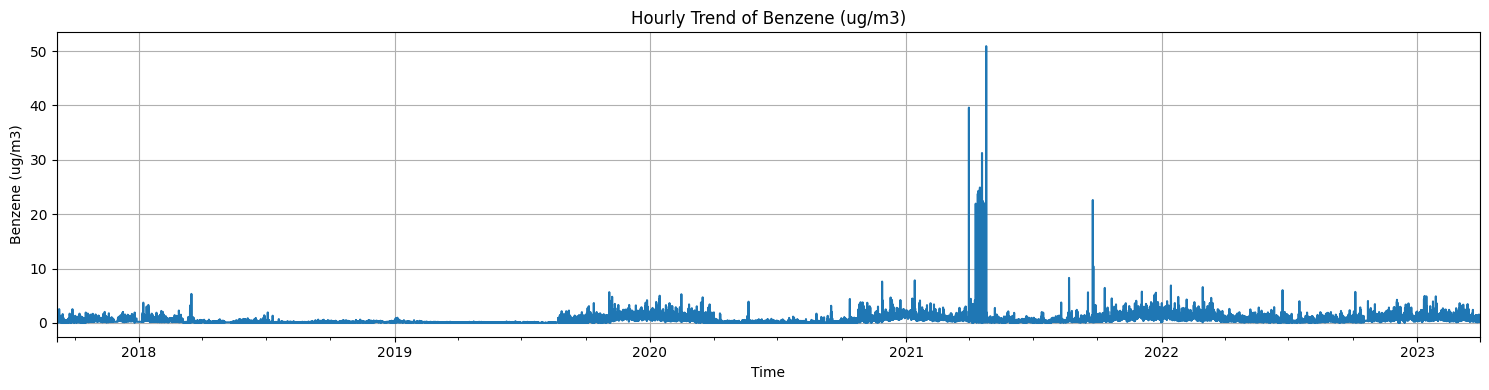

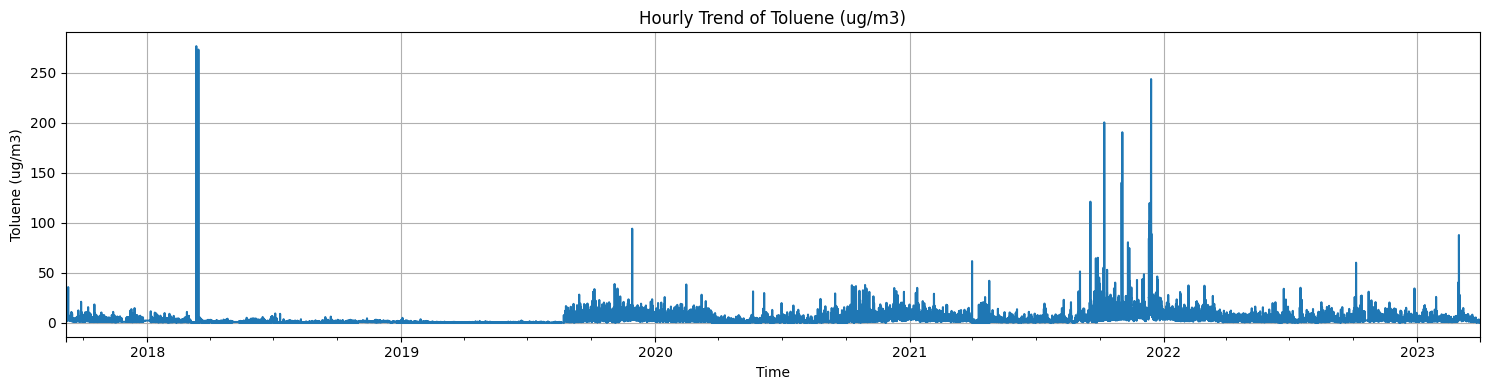

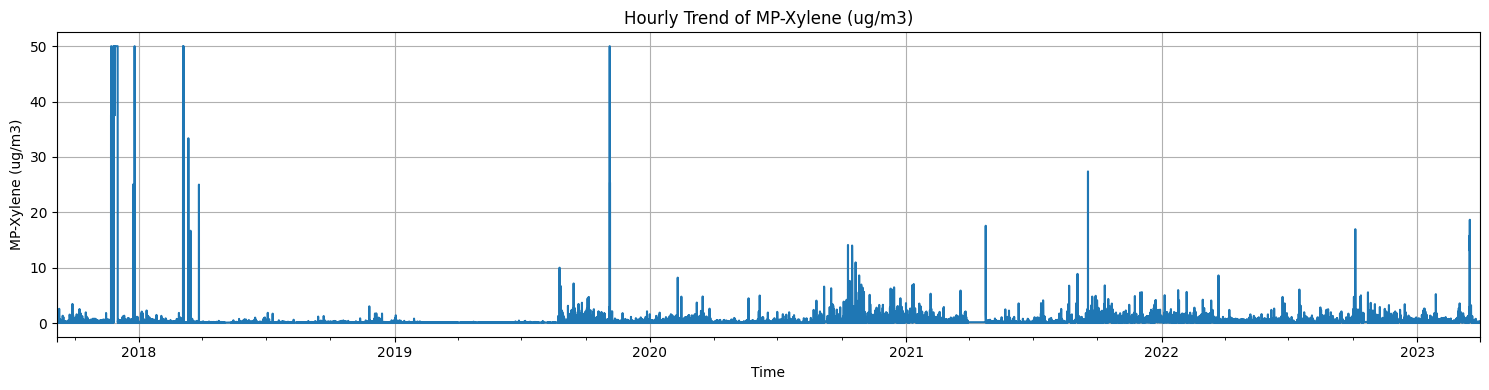

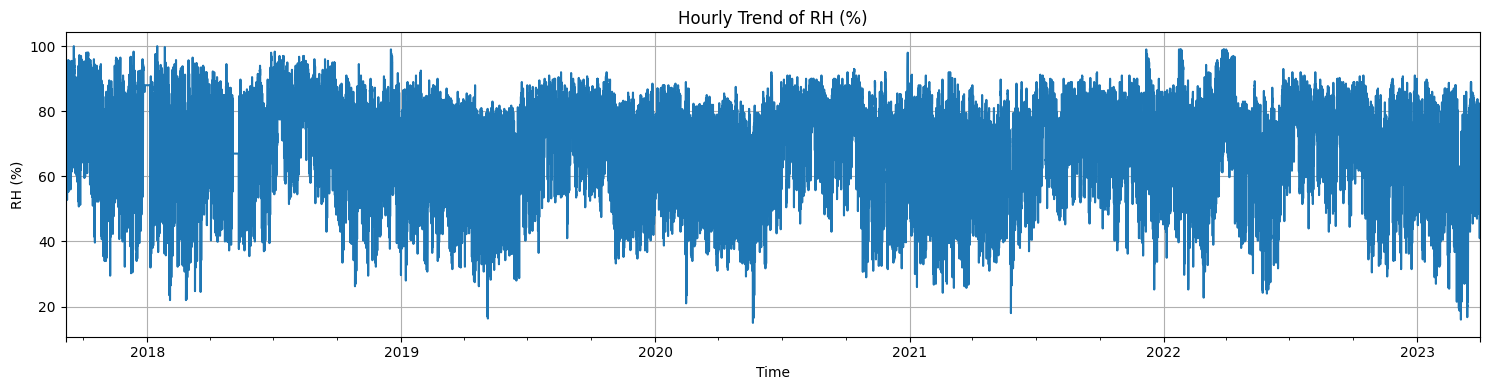

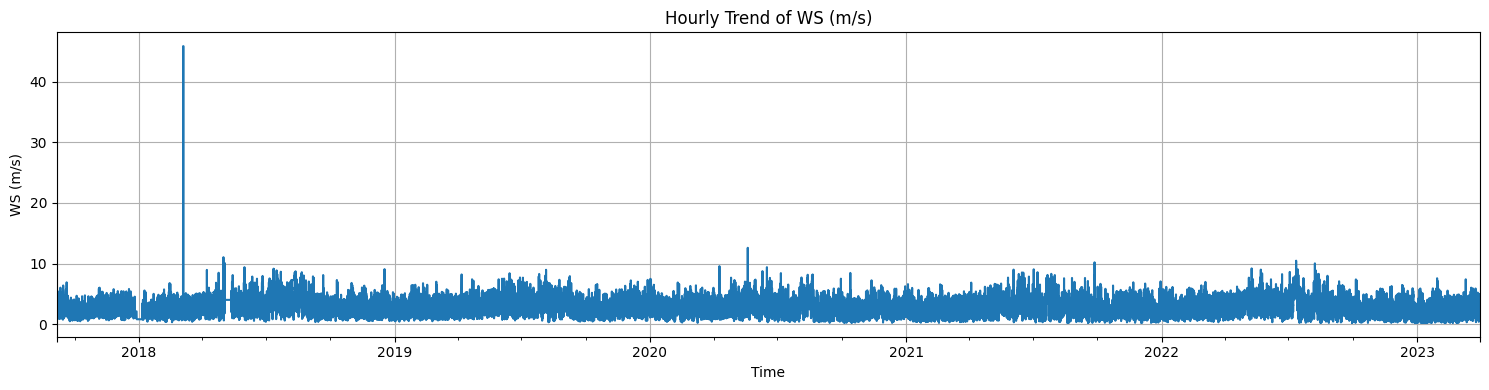

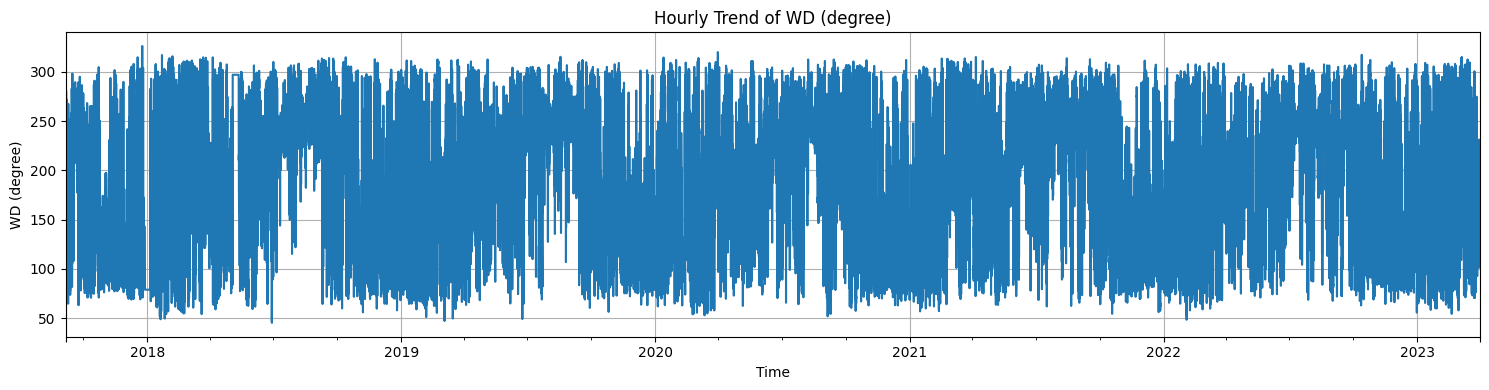

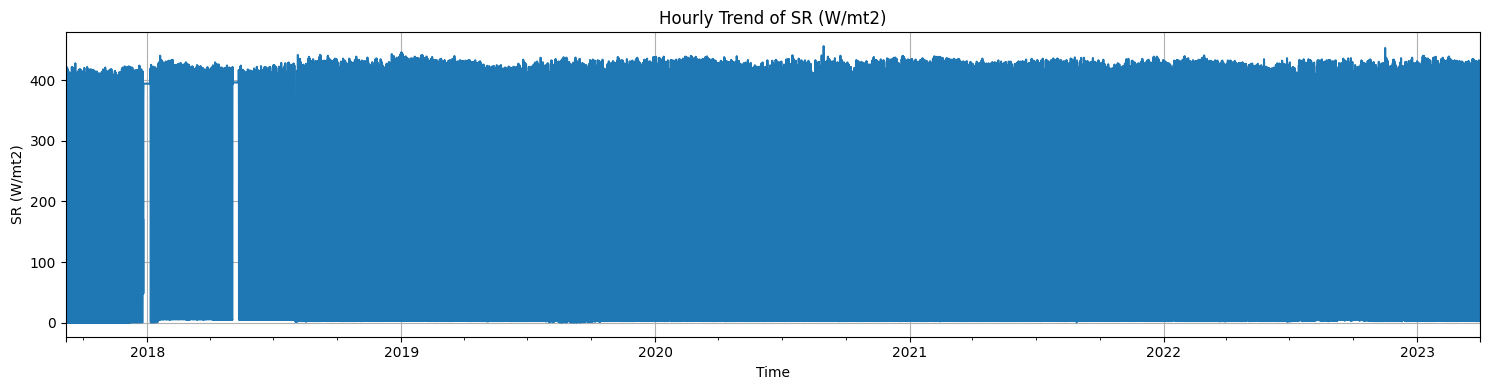

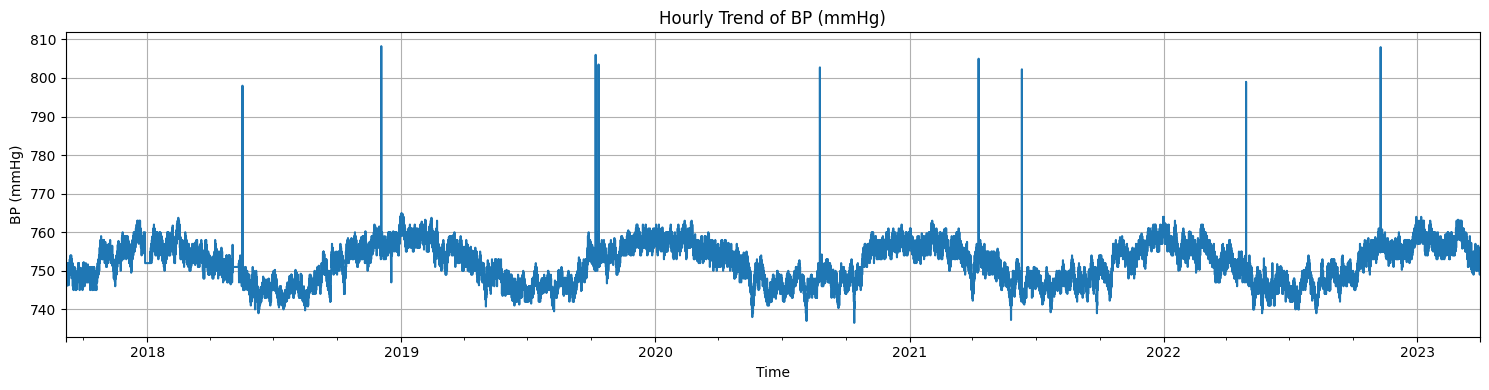

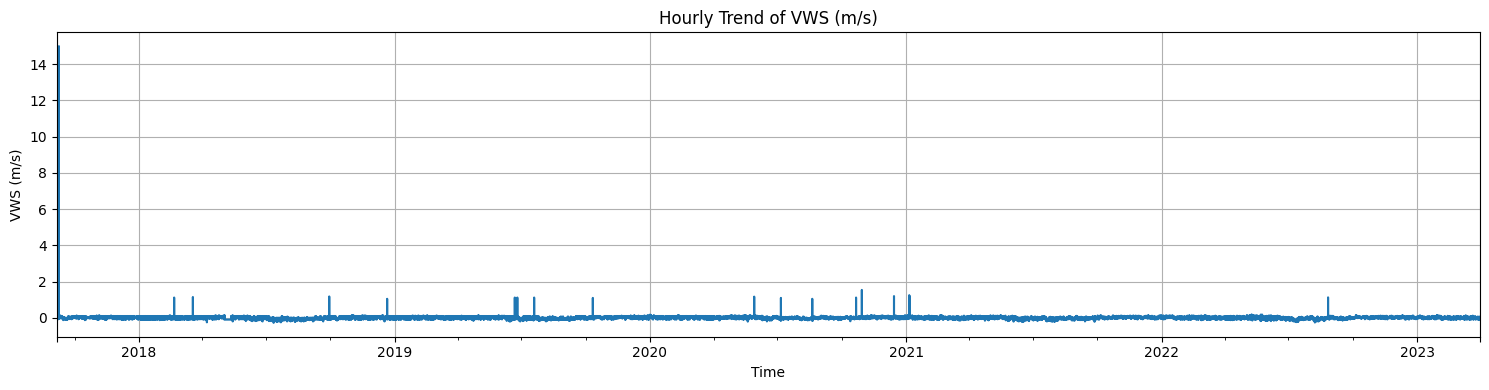

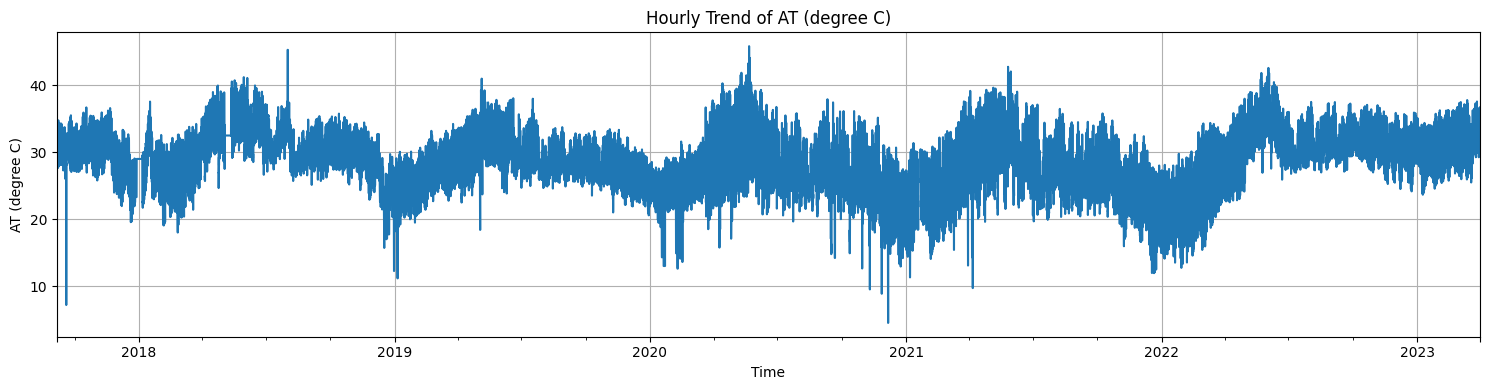

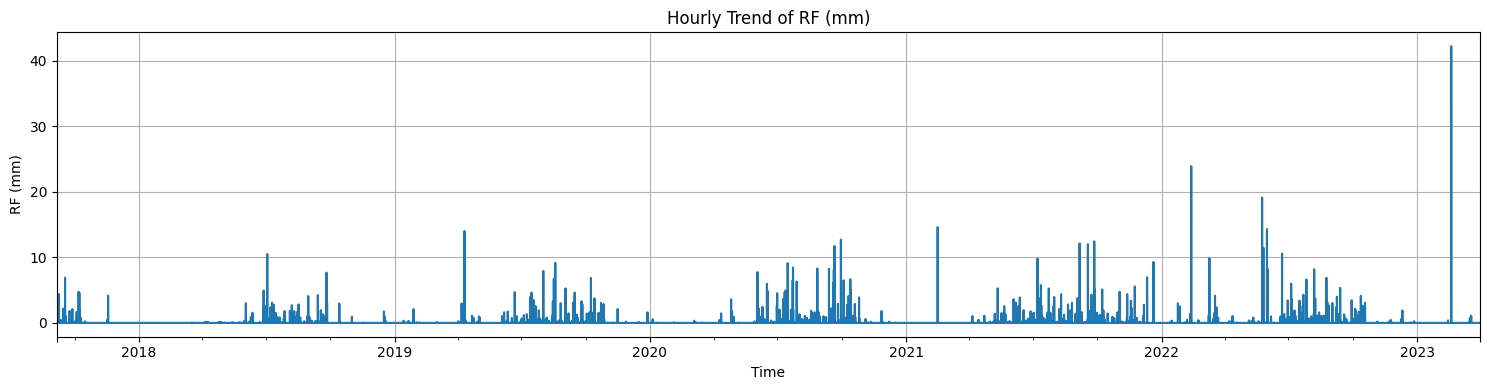

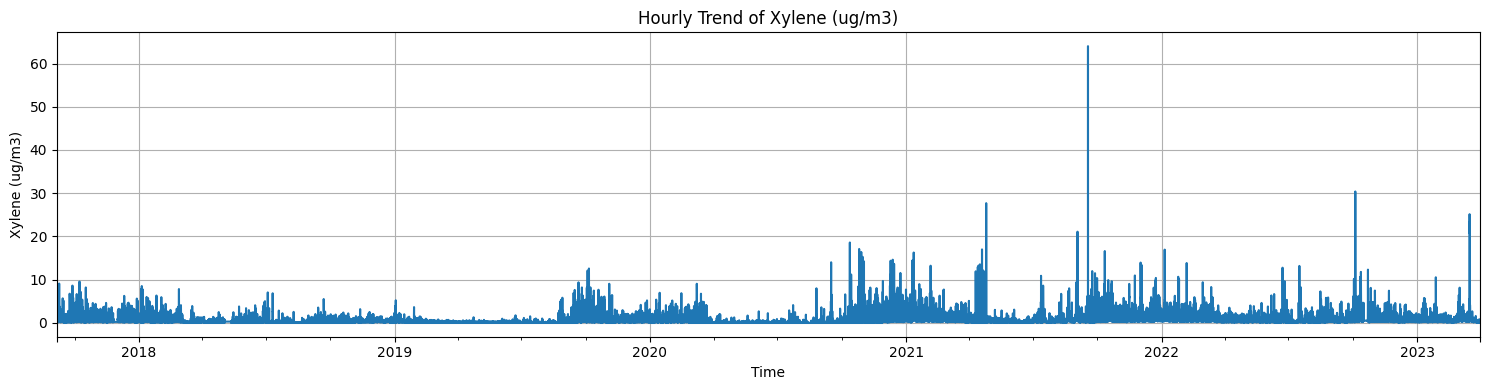

In [ ]:
df_hourly = df.resample('H').mean()
for column in df_hourly.columns:
    plt.figure(figsize=(15, 4))
    df_hourly[column].plot()
    plt.title(f'Hourly Trend of {column}')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Key Insights
1. **Strong seasonal trend**\
	Pollutants like PM2.5, PM10, SO2, and NO2 consistently peak during the colder months. Ozone and Air Temperature show the opposite pattern, peaking during the warmer months. This is an expected inverse relationship that the model must learn. BP and RH also display clear annual cycles.

2. **Clear daily cycles**\
	SR plot shows a daily cycle with radiation dropping to 0 every night. However, a data quality is found with flat-lined max values and a gap in early 2018. Air Temperature also shows daily fluctuatons on top of its annual cycle.

3. **Long term trends**\
	NO, NOx, and CO show a noticeable decrease n their overall levels since the high peaks observed in 2018.

4. **Extreme outliers**\
	WS, VWS, and BP show impossible, extreme spikes that are likely errors (as mentioned in the value breakdown). Organic compounds like Benzene, Toluene, and Xylene have an expected pattern of a very low baseline with sudden extreme spikes from specific timeline.

## Clip extreme values
There are seevral values that are deemed as impossible (due to errors, maybe) as seen on the values breakdown, plot, and trends. It is better to clip those values by choosing a high percentile, such s 99.9th percntile so the data variance is still respected.

In [ ]:
# List of columns to clip
columns_to_clip = ['WS (m/s)', 'VWS (m/s)', 'BP (mmHg)']

for col in columns_to_clip:
    # Calculate the 99.9th percentile
    percentile_99_9 = df[col].quantile(0.999)

    # Clip the values in the column
    df[col] = df[col].clip(upper=percentile_99_9)

    print(f"Clipped '{col}' at the 99.9th percentile value of: {percentile_99_9:.2f}")

Clipped 'WS (m/s)' at the 99.9th percentile value of: 8.68
Clipped 'VWS (m/s)' at the 99.9th percentile value of: 0.15
Clipped 'BP (mmHg)' at the 99.9th percentile value of: 763.00


These values look normal for all WS, VWS, and BP. Though we may lose the variance, but since the values are impossible, winsorization is the way to go.

## Transformation for Datetime and Wind Direction
WD is in degree, in which 0-360 has a big range, but in reality, 0 degree is the same as 360 degree. We will apply sine and cosine transformation so the LSTM model understands this relationship better, because without it, it will learn that 0 degree and 360 degree is far apart.

The same goes for datetime, where 23:00 is only one hour apart to 00:00. Without proper transformation, the model will learn that 23:00 is far apart with 00:00. So we will apply sine cosine transformation for this feature as well.

On top of that, we will extract the datetime to month, day, and hour so it will be extra helpful features for the model. It will try to learn the pattern and trends throughout the day, month, and year.

In [ ]:
# Transforming WD
df['WD_rad'] = df['WD (degree)'] * (2 * np.pi / 360)
df['WD_sin'] = np.sin(df['WD_rad'])
df['WD_cos'] = np.cos(df['WD_rad'])
df = df.drop(columns=['WD (degree)', 'WD_rad'])

In [ ]:
# Transforming datetime
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek
df['hour_of_day'] = df.index.hour

# Month (1-12)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Day (0-6)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Hour of day (0-23)
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

df = df.drop(columns=['month', 'day_of_week', 'hour_of_day'])

In [ ]:
df.head()

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),MP-Xylene (ug/m3),RH (%),WS (m/s),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3),WD_sin,WD_cos,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
From Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-05 14:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,79.50,0.10,3.50,0.10,69.00,3.20,372.00,747.00,0.10,33.80,0.00,0.50,-0.544639,-0.838671,-1.0,-1.836970e-16,0.781831,0.62349,-0.500000,-8.660254e-01
2017-09-05 15:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,62.50,0.15,2.83,0.08,70.50,4.10,290.75,747.25,0.05,32.22,0.00,0.48,0.642788,-0.766044,-1.0,-1.836970e-16,0.781831,0.62349,-0.707107,-7.071068e-01
2017-09-05 16:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,40.50,0.53,3.05,0.13,88.00,2.82,300.25,747.00,0.00,28.30,0.93,0.53,0.091502,-0.995805,-1.0,-1.836970e-16,0.781831,0.62349,-0.866025,-5.000000e-01
2017-09-05 17:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,34.43,0.48,4.88,0.28,88.75,1.72,225.50,747.75,0.00,28.77,0.00,1.85,-0.782608,-0.622515,-1.0,-1.836970e-16,0.781831,0.62349,-0.965926,-2.588190e-01
2017-09-05 18:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,33.00,0.57,5.15,0.38,88.50,1.97,11.25,748.25,0.00,28.25,0.00,2.17,0.964787,-0.263031,-1.0,-1.836970e-16,0.781831,0.62349,-1.000000,-1.836970e-16


## Train test split
The data will be splitted to 80% train, 10% val, and 10% test as stated on the case. The data will use the past 5 hours to predict the next hour air temperature.

After doing train test split, we will perform further data preprocessing, which is to scale the data using Robust Scaler. This is because we only want to fit_transform the scaler for train data so the scaler only learns from the training set, and just transform the test data to prevent data leakage.

In [ ]:
n = len(df)

train_end_idx = int(n * 0.8)
val_end_idx = int(n * 0.9)

train_df = df.iloc[:train_end_idx]
val_df = df.iloc[train_end_idx:val_end_idx]
test_df = df.iloc[val_end_idx:]

print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Training set shape: (39041, 28)
Validation set shape: (4880, 28)
Testing set shape: (4881, 28)


In [ ]:
target = 'AT (degree C)'
features = [col for col in df.columns if col != target]

## Scaling
Scaling will use RobustScaler as many columns have outliers. We have separate scalers for X and y values because the dimension will be different, and the y scaler will be saved for inverse transformation later for better interpretation.

In [ ]:
X_scaler = RobustScaler()
y_scaler = RobustScaler()

In [ ]:
X_scaler.fit(train_df[features])
y_scaler.fit(train_df[[target]])

RobustScaler()

In [ ]:
train_df_scaled = train_df.copy()
val_df_scaled = val_df.copy()
test_df_scaled = test_df.copy()

In [ ]:
train_df_scaled[features] = X_scaler.transform(train_df[features])
train_df_scaled[target] = y_scaler.transform(train_df[[target]])

val_df_scaled[features] = X_scaler.transform(val_df[features])
val_df_scaled[target] = y_scaler.transform(val_df[[target]])

test_df_scaled[features] = X_scaler.transform(test_df[features])
test_df_scaled[target] = y_scaler.transform(test_df[[target]])

In [ ]:
train_df_scaled.head()

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),MP-Xylene (ug/m3),RH (%),WS (m/s),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3),WD_sin,WD_cos,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
From Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-05 14:00:00,0.000000,-0.230769,-0.086957,-0.132432,-0.182909,-0.265193,-0.379310,-0.652174,0.866354,-0.230769,0.471390,0.000000,-0.181818,0.321782,0.642767,-0.65625,1.428571,1.082474,0.00,0.307692,-0.256936,-0.451938,-0.732051,-1.793007e-16,0.5,0.554958,-0.353553,-6.123724e-01
2017-09-05 15:00:00,-0.051613,-0.161538,-1.086957,0.079279,-0.125937,-0.414365,-0.586207,-0.521739,0.467761,-0.153846,0.288828,-0.142857,-0.113636,0.767327,0.438365,-0.62500,0.714286,0.810997,0.00,0.276923,0.443184,-0.351679,-0.732051,-1.793007e-16,0.5,0.554958,-0.500000,-5.000000e-01
2017-09-05 16:00:00,-0.180645,-0.065385,1.826087,1.163063,1.241379,-0.703867,-0.427203,-0.586957,-0.048066,0.430769,0.348774,0.214286,0.681818,0.133663,0.462264,-0.65625,0.000000,0.137457,0.93,0.353846,0.118140,-0.668859,-0.732051,-1.793007e-16,0.5,0.554958,-0.612372,-3.535534e-01
2017-09-05 17:00:00,-0.135484,-0.407692,-0.234783,0.730631,0.569715,-0.475138,-0.436782,-0.369565,-0.190387,0.353846,0.847411,1.285714,0.715909,-0.410891,0.274214,-0.56250,0.000000,0.218213,0.00,2.384615,-0.397246,-0.153539,-0.732051,-1.793007e-16,0.5,0.554958,-0.683013,-1.830127e-01
2017-09-05 18:00:00,-0.283871,-0.492308,-0.721739,1.145045,0.866567,-1.014365,-0.555556,-0.478261,-0.223916,0.492308,0.920981,2.000000,0.704545,-0.287129,-0.264780,-0.50000,0.000000,0.128866,0.00,2.876923,0.633039,0.342721,-0.732051,-1.793007e-16,0.5,0.554958,-0.707107,-1.731912e-16


Now that all values are within the same range, hopefully the model will work well! :)

## Create sequence
Creating sequence is necessary for time series analysis because the data is split based on the time, not randomness. Since the objective is to predict the Air Temperature (AT) for the next hour by using the last 5 hours data, the input_length is set to 5 and the output_length is set to 1.

In [ ]:
def create_sequences(data, input_length, output_length):
    X, y = [], []
    for i in range(len(data) - input_length - output_length + 1):
        input_seq = data.iloc[i:i + input_length]
        output_seq = data.iloc[i + input_length:i + input_length + output_length]

        X.append(input_seq.values)
        y.append(output_seq[[target]].values)

    return np.array(X), np.array(y)

input_length = 5  # 5 hours of past data
output_length = 1 # 1 hour ahead

X_train, y_train = create_sequences(train_df_scaled, input_length, output_length)
X_val, y_val = create_sequences(val_df_scaled, input_length, output_length)
X_test, y_test = create_sequences(test_df_scaled, input_length, output_length)

print(f"X_train shape: {X_train.shape} -> (Samples, Time Steps, Features)")
print(f"y_train shape: {y_train.shape} -> (Samples, Prediction Time Steps, Target Features)\n")

print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}\n")

print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}\n")

X_train shape: (39036, 5, 28) -> (Samples, Time Steps, Features)
y_train shape: (39036, 1, 1) -> (Samples, Prediction Time Steps, Target Features)

X_val shape:   (4875, 5, 28)
y_val shape:   (4875, 1, 1)

X_test shape:  (4876, 5, 28)
y_test shape:  (4876, 1, 1)



We have split the data to 80/10/10 train/val/test as mentioned in the case. The data is 3 dimensional, with the pattern of # of samples, time steps, and # of features.

# b. Model 1: LSTM
As mentioned on the case, the hidden size for this first model is 10 units and the output is 1 unit because we only want to predict the Air Temperature. The input shape from LSTM is the time steps and features, so we will use shape[1] and shape[2].

We will set an Early Stopping callback so it will stop the epoch when the val_loss doesn't improve after 5 consecutive epochs to avoid redundance.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential([
    LSTM(units=10, input_shape=input_shape),
    Dense(units=1, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss=tf.keras.losses.MeanSquaredError())

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 10)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,571 (6.14 KB)

 Trainable params: 1,571 (6.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.5616 - val_loss: 0.2905
Epoch 2/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1783 - val_loss: 0.1655
Epoch 3/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1025 - val_loss: 0.1142
Epoch 4/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0741 - val_loss: 0.0861
Epoch 5/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0595 - val_loss: 0.0682
Epoch 6/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0500 - val_loss: 0.0582
Epoch 7/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0447 - val_loss: 0.0510
Epoch 8/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0390 - val_loss: 0.0445
Epoch 9/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0360 - val_loss: 0.0385
Epoch 10/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0332 - val_loss: 0.0371
Epoch 11/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0301 - val_loss: 0.0337
Epoch 12/100
122

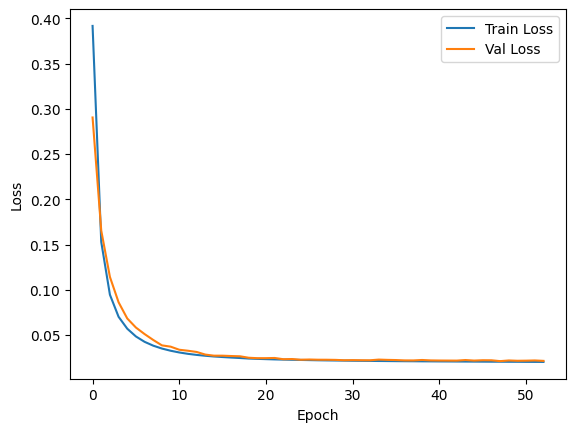

In [ ]:
# Plot the loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Inference
- The model has fast initial learning with very high train and val loss (0.4) and the loss drops very steeply in the first 10 epochs. This shows that the model starts with no knowledge, but learns the patterns in the data quickly.
- The train and val loss converge, which means that the model isn't just memorizing but it is learning the patterns of the data and applied what it has learned to an unseen data (validation data).
- No signs of overfitting, as the model converges on both train and validation dataset and no signs of increasing loss.
- The flat line on the last few epochs suggests that the model has learned as much as it can and the training stops, thanks to EarlyStopping.

# c. Model 2: LSTM Modified
This second model will be made as more complex because the previous model is simple. We want to see if the simple or complex model will perform better on this dataset. I will combine the layers with Dropout layers to see if it can minimize the overfitting or not, though the overfitting is not likely to happen.

In [ ]:
model2 = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=input_shape),
    Dropout(0.2),

    LSTM(units=64),
    Dropout(0.2),

    Dense(units=32, activation='relu'),

    Dense(units=1, activation='linear')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 5, 128)         │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,905 (515.25 KB)

 Trainable params: 131,905 (515.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss=tf.keras.losses.MeanSquaredError())

In [ ]:
history2 = model2.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - loss: 0.2111 - val_loss: 0.0808
Epoch 2/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - loss: 0.0750 - val_loss: 0.0700
Epoch 3/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.0595 - val_loss: 0.0528
Epoch 4/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - loss: 0.0495 - val_loss: 0.0397
Epoch 5/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 0.0467 - val_loss: 0.0434
Epoch 6/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 0.0428 - val_loss: 0.0365
Epoch 7/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.0392 - val_loss: 0.0399
Epoch 8/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 0.0352 - val_loss: 0.0360
Epoch 9/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.0348 - val_loss: 0.0274
Epoch 10/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 0.0317 - val_loss: 0.0287
Epoch 11/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0299 - val_loss: 0.02

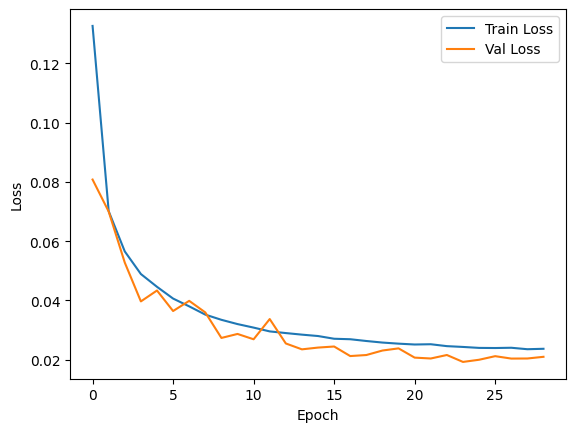

In [ ]:
# Plot the loss
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Inference
- The training stops earlier at epoch 29, this is because the model has reached its best performance quicker than the first model, likely because of a more complex architecture.
- The final loss for both training and validation is about the same as the first model, but the first model wins with lower training loss (reaching 0.19).
- The most noticeable feature is that the val loss is much more bumpy than the first plot. This is common for models with Dropout. Despite this, the val loss is overall decreasing, so it suggests that this model also does not overfit.

# d. Model 3: LSTM Baseline Tuned
The 3rd model is the tuned version of LSTM baseline as it has slightly higher performance than the complex model. I will tune several parameters here: the units size, dropout rate, and learning rate.

In [ ]:
def build_model(hp):
    input_shape = (X_train.shape[1], X_train.shape[2])

    model = Sequential()
    hp_units_1 = hp.Int('units_1', min_value=10, max_value=80, step=10)
    model.add(LSTM(units=hp_units_1, return_sequences=False, input_shape=input_shape))

    hp_dropout = hp.Float('dropout_rate', min_value=0, max_value=0.4, step=0.05) # from no dropout (like the first model) to using dropout
    model.add(Dropout(hp_dropout))

    model.add(Dense(units=1, activation='linear'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mean_squared_error'
    )

    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='lstm_tuning_dir',
    project_name='AT_pred_params'
)

In [ ]:
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stopping])

Trial 5 Complete [00h 01m 19s]
val_loss: 0.021622434258461

Best val_loss So Far: 0.018529120832681656
Total elapsed time: 00h 13m 06s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(f"""
Optimal units in LSTM layer: {best_hps.get('units_1')}
Optimal dropout rate: {best_hps.get('dropout_rate'):.2f}
Optimal learning rate: {best_hps.get('learning_rate')}
""")


Optimal units in LSTM layer: 50
Optimal dropout rate: 0.15
Optimal learning rate: 0.001



The best val loss is 0.018, with 50 units of hidden size, 0.15 dropout rate, and 0.001 learning rate.

In [ ]:
model3 = tuner.hypermodel.build(best_hps)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        15,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,851 (61.92 KB)

 Trainable params: 15,851 (61.92 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss=tf.keras.losses.MeanSquaredError())

In [ ]:
history3 = model3.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.1312 - val_loss: 0.0314
Epoch 2/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0359 - val_loss: 0.0286
Epoch 3/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0277 - val_loss: 0.0271
Epoch 4/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0276 - val_loss: 0.0245
Epoch 5/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0258 - val_loss: 0.0217
Epoch 6/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0261 - val_loss: 0.0190
Epoch 7/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0254 - val_loss: 0.0273
Epoch 8/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0254 - val_loss: 0.0205
Epoch 9/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0244 - val_loss: 0.0199
Epoch 10/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0234 - val_loss: 0.0235
Epoch 11/150
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0257 - val_loss: 0.0190


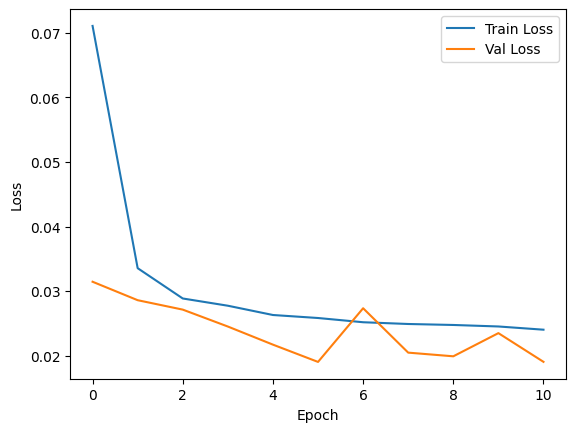

In [ ]:
# Plot the loss
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Inference
- This model has the fastest training as it stops at epoch 11 (2x faster than Model 2 and 5x faster than Model 1)
- It has the lowest val loss of 3 models, which sugests that the model is performing better on new, unseen data.
- During the training, the Dropout layer randomly deactivates neurons which result in bumpy loss, but overall still very low.

# e. Evaluation
We will use the model to predict the test data. However, since we used scaler earlier, we need to perform inverse transform to get the actual predicted data. The metrics used here is MAE (Mean Absolute Error), MSE (Mean Squared Error), and R2 score.

In [ ]:
model1_pred_scaled = model.predict(X_test)
model2_pred_scaled = model2.predict(X_test)
model3_pred_scaled = model3.predict(X_test)

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
model1_pred = y_scaler.inverse_transform(model1_pred_scaled)
model2_pred = y_scaler.inverse_transform(model2_pred_scaled)
model3_pred = y_scaler.inverse_transform(model3_pred_scaled)

In [ ]:
model1_pred[:5]

array([[28.900331],
       [27.875437],
       [28.729288],
       [28.723455],
       [28.61795 ]], dtype=float32)

In [ ]:
test_df[target].head()

,AT (degree C)
From Date,
2022-09-09 15:00:00,29.40
2022-09-09 16:00:00,29.92
2022-09-09 17:00:00,29.52
2022-09-09 18:00:00,29.42
2022-09-09 19:00:00,29.12


In [ ]:
y_test_reshaped = y_test.reshape(-1, 1)
y_test_actual = y_scaler.inverse_transform(y_test_reshaped)
y_test_actual[:5]

array([[28.77],
       [28.95],
       [28.92],
       [29.25],
       [29.48]])

In [ ]:
predictions = {
    'Model 1 (LSTM)': model1_pred,
    'Model 2 (LSTM Modified)': model2_pred,
    'Model 3 (LSTM Baseline Tuned)': model3_pred
}

In [ ]:
results_list = []

for model_name, pred in predictions.items():
    mae = mean_absolute_error(y_test_actual, pred)
    mse = mean_squared_error(y_test_actual, pred)
    r2 = r2_score(y_test_actual, pred)

    results_list.append({
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'R-squared': r2
    })

In [ ]:
results_df = pd.DataFrame(results_list)
results_df = results_df.set_index('Model')

In [ ]:
results_df

,MAE,MSE,R-squared
Model,,,
Model 1 (LSTM),0.737125,0.919030,0.869581
Model 2 (LSTM Modified),0.701035,0.774790,0.890050
Model 3 (LSTM Baseline Tuned),0.572590,0.542816,0.922969


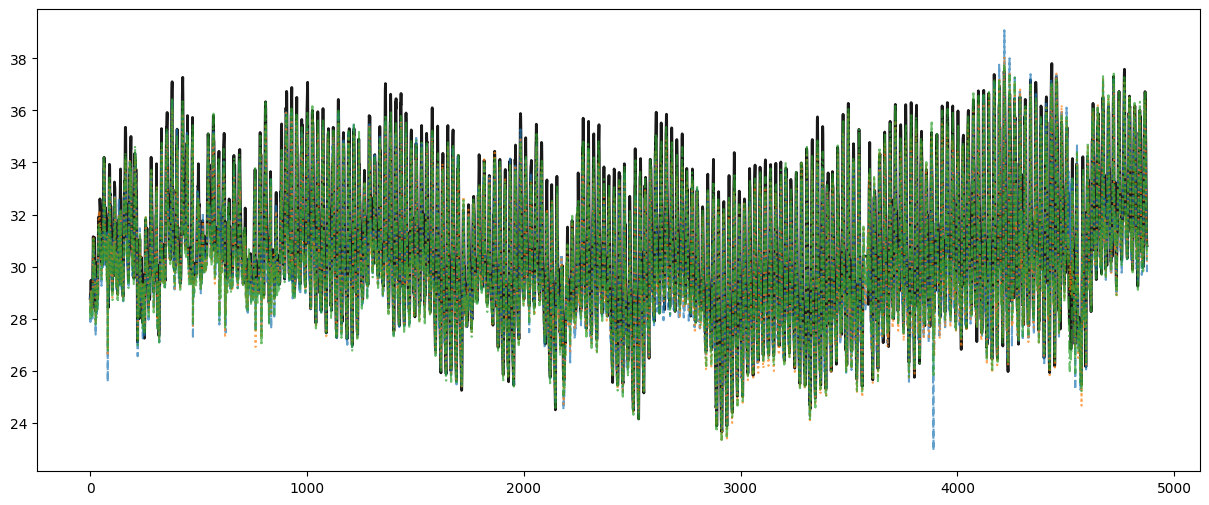

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Actual Air Temperature', color='black', alpha=0.9, linewidth=2)

plt.plot(model1_pred, label='LSTM', linestyle='--', alpha=0.7)
plt.plot(model2_pred, label='LSTM Modified', linestyle=':', alpha=0.7)
plt.plot(model3_pred, label='LSTM Baseline Tuned', linestyle='-.', alpha=0.7)


- MAE is the average error of the predictions, lower is better. An MAE of 0.5 means the model's predictions are, on average, 0.5 degrees off from the actual temperature.
- MSE is similar to MAE, but it penalizes larger errors more heavily. Lower is better.
- R2 score tells the percentage of changes in the actual temperature is explained by the model, higher is better.

## Error Analysis
- Model 1 has the highest error (MAE 0.73, MSE 0.91)
- Model 2 has lower error (MAE 0.73, MSE 0.77)
- Model 3 has the lowest error (MAE 0.57, MSE 0.54) -> Most accurate predictions

## Line plot
Confirms that all models are successful in predicting the temperature. While all models are good, the differences are small enough that they look similar on a large scale. The metrics table gives us the precise measurement to find the best one.

## R-square
- Model 1 has the lowest (but still good) R2 of 87%
- Model 2 has the moderate R2 of 89%
- Model 3 has the best R2 of 92% which fits the data better than the two other models

## Verdict
Model 3 (LSTM Baseline Tuned) is the best model that aces each evaluation metric. This may happen because we have tuned the parameters and find the combinations to get the best result. Aside from that, using all the decent features from the dataset and did proper preprocessing also lead to good results.

*p.s.: yay finally a decent model after all those poor-performing models on all GSLC and mid exam :D*

# f. Video Explanation
Video is accessible [here](https://youtu.be/6zaR3QXyipA)\
Powerpoint is accessible [here](https://www.figma.com/deck/yZATHcO1pfzO4fWcb3yHiU/DL-PPT?node-id=0-28&t=ckPAFLmqBsGzmOmD-1)

# g. Bonus Question
To determine if this problem can be considered as multivariate time series is to ask, is it helpful for the model to learn from the other features related to the target or not? If yes, then it is a multivariate problem. If not (the model can work well just by looking on the target variable), it is a univariate problem.

- Example of univariate problem: Predicting the next hour temperature by using the past 5 hours temperature only.
- Example of multivariate problem: Predicting the next hour temperature by using the past 5 hours characteristics (temperature, wind speed, wind direction, humidity etc)

This problem can be solved using the multivariate time series. As we can see, the model performs decently by learning from multiple features. These features give LSTM richer context of the data and air quality, so this relationship between variables help the model to make a more accurate prediction.